In [1]:
import re
import os
import sys
import time
import numpy as np
import scipy as sp
from utils import *
from math import log
from h5py import File
from numpy.linalg import *
from scipy.linalg import *
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
from mindquantum.framework import *
from mindquantum.core.gates import *
from scipy.stats import unitary_group
from mindquantum.core.circuit import *
from IPython.display import display_svg
from mindquantum.core.operators import *
from mindquantum.algorithm.nisq import *
from mindquantum.simulator import Simulator
from mindquantum.algorithm.compiler import *

np.set_printoptions(linewidth=400)

In [2]:
def Pd(name, d, ind):
    if len(ind) != 2:
        raise ValueError(f'{name} index length {len(ind)} should be 2')
    if len(set(ind)) != len(ind):
        raise ValueError(f'{name} index {ind} cannot be repeated')
    if min(ind) < 0 or max(ind) >= d:
        raise ValueError(f'{name} index {ind} should in 0 to {d-1}')
    mat = np.eye(d, dtype=np.complex128)
    if name == 'X':
        mat[np.ix_(ind, ind)] = X.matrix()
    elif name == 'Y':
        mat[np.ix_(ind, ind)] = Y.matrix()
    elif name == 'Z':
        mat[np.ix_(ind, ind)] = Z.matrix()
    return mat


def Rd(name, d, ind, pr):
    if len(ind) != 2:
        raise ValueError(f'R{name} index length {len(ind)} should be 2')
    if len(set(ind)) != len(ind):
        raise ValueError(f'R{name} index {ind} cannot be repeated')
    if min(ind) < 0 or max(ind) >= d:
        raise ValueError(f'R{name} index {ind} should in 0 to {d-1}')
    mat = np.eye(d, dtype=np.complex128)
    if name == 'X':
        mat[np.ix_(ind, ind)] = RX(pr).matrix()
    elif name == 'Y':
        mat[np.ix_(ind, ind)] = RY(pr).matrix()
    elif name == 'Z':
        mat[np.ix_(ind, ind)] = RZ(pr).matrix()
    return mat


def Ud(d, ind, pr):
    if len(ind) != 2:
        raise ValueError(f'U3 index length {len(ind)} should be 2')
    if len(set(ind)) != len(ind):
        raise ValueError(f'U3 index {ind} cannot be repeated')
    if min(ind) < 0 or max(ind) >= d:
        raise ValueError(f'U3 index {ind} should in 0 to {d-1}')
    if len(pr) != 3:
        raise ValueError(f'U3 params length {len(pr)} should be 3')
    theta, phi, lam = pr
    mat = np.eye(d, dtype=np.complex128)
    mat[np.ix_(ind, ind)] = U3(theta, phi, lam).matrix()
    return mat


def INC(d):
    mat = np.eye(d, dtype=np.complex128)
    mat = mat[[d - 1] + list(range(d - 1))]
    return mat


def CINC(d):
    return block_diag(np.eye(d**2 - d), INC(d))


def GCX(d, ind, m):
    if m < 0 or m >= d:
        raise ValueError(f'¦{m}⟩ control state should in 0 to {d-1}')
    return block_diag(np.eye(d * m), Pd('X', d, ind), np.eye(d * (d - m - 1)))

def GCP(name, d, ind, m):
    if m < 0 or m >= d:
        raise ValueError(f'¦{m}⟩ control state should in 0 to {d-1}')
    return block_diag(np.eye(d * m), Pd(name, d, ind), np.eye(d * (d - m - 1)))

def GCR(name, d, ind, pr, m):
    if m < 0 or m >= d:
        raise ValueError(f'¦{m}⟩ control state should in 0 to {d-1}')
    return block_diag(np.eye(d * m), Rd(name, d, ind, pr), np.eye(d * (d - m - 1)))

def GCU(d, ind, U, m):
    if m < 0 or m >= d:
        raise ValueError(f'¦{m}⟩ control state should in 0 to {d-1}')
    mat = np.eye(d, dtype=np.complex128)
    mat[np.ix_(ind, ind)] = U
    return block_diag(np.eye(d * m), mat, np.eye(d * (d - m - 1)))

Hamiltonian Dimension: (16, 16)
Number of qubits: 4
Number of params: 18
Number of gates: 54
Loss: 0.717194687693114, Fidelity: 0.282805312306886,  10, 0.0028
Loss: 0.256061257012965, Fidelity: 0.743938742987035,  20, 0.0051
Loss: 0.253858445427711, Fidelity: 0.746141554572289,  30, 0.0074
Loss: 0.253429660966418, Fidelity: 0.746570339033582,  40, 0.0095
Loss: 0.248979200296595, Fidelity: 0.751020799703405,  50, 0.0117
Loss: 0.167038836265820, Fidelity: 0.832961163734180,  60, 0.0139
Loss: 0.000010094337641, Fidelity: 0.999989905662359,  70, 0.0162
Loss: 0.000000000001456, Fidelity: 0.999999999998544,  80, 0.0183
Loss: 0.000000000000000, Fidelity: 1.000000000000000,  90, 0.0207
Optimization terminated successfully.
Optimal: 0.00000000000000033307
psi norm: 0.81907864905116134491
psi fidelity: 0.99999999999999988898
Is state symmetric: True True


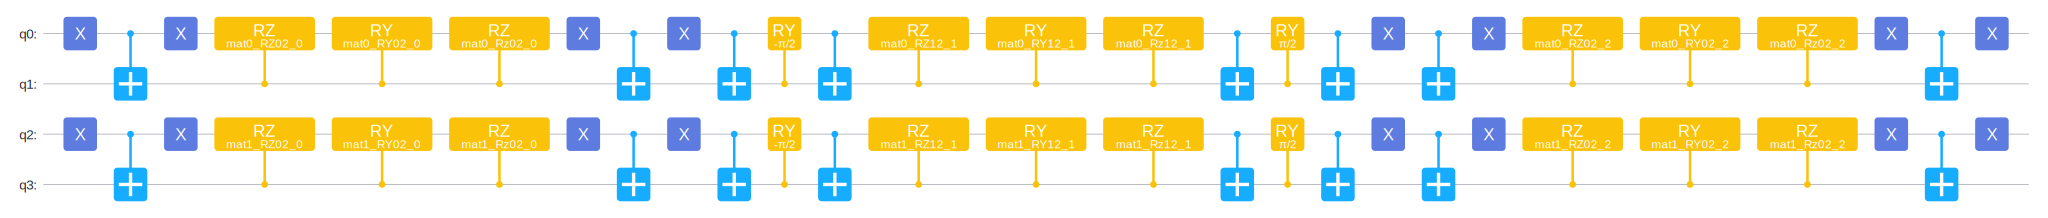

In [3]:
def fun(p0, sim_grad, args=None):
    f, g = sim_grad(p0)
    f = 1 - np.real(f)[0][0]
    g = -np.real(g)[0][0]
    if args is not None:
        args.append(f)
        i = len(args)
        if i % 10 == 0:
            global start
            t = time.perf_counter() - start
            print('Loss: %.15f, Fidelity: %.15f, %3d, %.4f' % (f, 1 - f, i, t))
    return f, g


def Ub(basis, d, ind, pr, obj):
    if d != 3:
        raise ValueError('Only works when d = 3')
    if len(ind) != 2:
        raise ValueError(f'U3 index length {len(ind)} should be 2')
    if len(set(ind)) != len(ind):
        raise ValueError(f'U3 index {ind} cannot be repeated')
    if min(ind) < 0 or max(ind) >= d:
        raise ValueError(f'U3 index {ind} should in 0 to {d-1}')
    if len(pr) != 3:
        raise ValueError(f'U3 params length {len(pr)} should be 3')
    circ = Circuit()
    if ind == [0, 1]:
        corr = Circuit() + X(obj[1], obj[0]) + RY(np.pi / 2).on(obj[0], obj[1]) + X(obj[1], obj[0]) + X(obj[1])
    elif ind == [0, 2]:
        corr = Circuit() + X(obj[0]) + X(obj[1], obj[0]) + X(obj[0])
    elif ind == [1, 2]:
        corr = Circuit() + X(obj[1], obj[0]) + RY(-np.pi / 2).on(obj[0], obj[1]) + X(obj[1], obj[0])
    circ += corr
    if basis == 'zyz':
        circ += RZ(pr[0]).on(obj[0], obj[1])
        circ += RY(pr[1]).on(obj[0], obj[1])
        circ += RZ(pr[2]).on(obj[0], obj[1])
    elif basis == 'u3':
        theta, phi, lam = pr
        circ += U3(theta, phi, lam).on(obj[0], obj[1])
    else:
        raise ValueError(f'Wrong basis {basis} is not in {opt_basis}')
    circ += corr.hermitian()
    return circ


def one_qutrit_symmetric_ansatz(gate: UnivMathGate, basis: str = 'zyz', with_phase: bool = False):
    name = f'{gate.name}_'
    obj = gate.obj_qubits
    circ = Circuit()
    index = [[0, 2], [1, 2], [0, 2]]
    if basis == 'zyz':
        for i, ind in enumerate(index):
            str_pr = f'{"".join(str(i) for i in ind)}_{i}'
            pr = [f'{name}RZ{str_pr}', f'{name}RY{str_pr}', f'{name}Rz{str_pr}']
            circ += Ub(basis, d, ind, pr, obj)
    elif basis == 'u3':
        for i, ind in enumerate(index):
            str_pr = f'{"".join(str(i) for i in ind)}_{i}'
            pr = [f'{name}𝜃{str_pr}', f'{name}𝜑{str_pr}', f'{name}𝜆{str_pr}']
            circ += Ub(basis, d, ind, pr, obj)
    else:
        raise ValueError(f'Wrong basis {basis} is not in {opt_basis}')
    if with_phase:
        for i in obj:
            circ += GlobalPhase(f'phase').on(i)
    return circ


opt_basis = ['zyz', 'u3']

d, m = 3, 2
nq = d - 1
Id = su2_encoding(np.eye(d))
p = np.eye(Id.shape[0]) - Id

circ = Circuit()
ansatz = Circuit()
for i in range(m):
    mat = unitary_group.rvs(d)
    mat = su2_encoding(mat) + p
    obj = list(range(nq * i, nq * (i + 1)))
    gate = UnivMathGate(f'mat{i}', mat).on(obj)
    circ += gate
    ansatz += one_qutrit_symmetric_ansatz(gate, 'zyz')

nq = circ.n_qubits
sim = Simulator('mqvector', nq)
sim.apply_circuit(circ)
psi = sim.get_qs()

rho = np.outer(psi, psi.conj())
Ham = Hamiltonian(csr_matrix(rho))
print('Hamiltonian Dimension:', rho.shape)

p_name = ansatz.ansatz_params_name
p_num = len(p_name)
g_num = sum(1 for _ in ansatz)
print('Number of qubits: %d' % nq)
print('Number of params: %d' % p_num)
print('Number of gates: %d' % g_num)

sim.reset()
sim_grad = sim.get_expectation_with_grad(Ham, ansatz)
p0 = np.random.uniform(-1, 1, p_num)
fun(p0, sim_grad)
start = time.perf_counter()
res = minimize(fun, p0, args=(sim_grad, []), method='CG', jac=True, tol=1e-8)

print(res.message)
print('Optimal: %.20f' % res.fun)

sim.reset()
pr_res = dict(zip(p_name, res.x))
sim.apply_circuit(ansatz.apply_value(pr_res))
psi_res = sim.get_qs()
print('psi norm: %.20f' % norm(psi - psi_res, 2))
print('psi fidelity: %.20f' % fidelity(psi, psi_res))
print('Is state symmetric:', is_symmetric(psi, m), is_symmetric(psi_res, m))

ansatz.svg()

[[ 1.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          1.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j          0.91615867-0.38947545j  0.0358917 +0.08760114j  0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j          0.07291218-0.06038201j -0.6248494 -0.77498455j  0

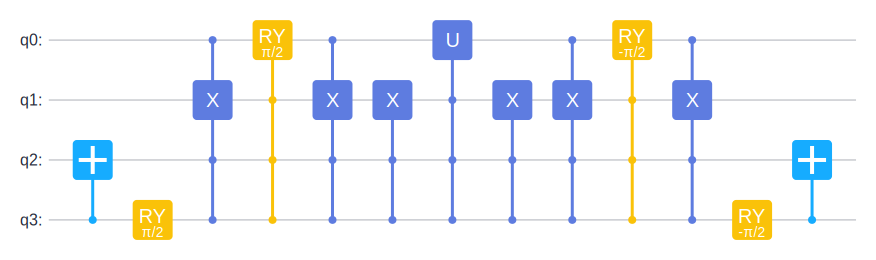

In [4]:
# Qubit ansatz of qutrit controlled unitary gate
d = 3
m = 1
ind = [0, 1]
U = unitary_group.rvs(2)
print(GCU(d, ind, U, m))

p = np.eye(2**((d - 1) * 2)) - su2_encoding(np.eye(d**2), 2)
GCUe = su2_encoding(GCU(d, ind, U, m), 2)
GCUp = GCUe + p
# print(GCUp)

circ = Circuit()
if m == 0:
    if ind == [0, 1]:
        corr = Circuit() + X(2) + X(3) + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(
            1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(2) + X(3) + X(0, [2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(2) + X(3) + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
elif m == 1:
    if ind == [0, 1]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(0, [2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
elif m == 2:
    if ind == [0, 1]:
        corr = Circuit() + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(0, [2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
circ += corr
circ += UnivMathGate('U', U).on(0, [1, 2, 3])
circ += corr.hermitian()
print(circ.matrix())
print(np.allclose(GCUp, circ.matrix()))
circ.svg()

[[ 1.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j       ]
 [ 0.        +0.j         1.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j       ]
 [ 0.        +0.j         0.        +0.j         1.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.

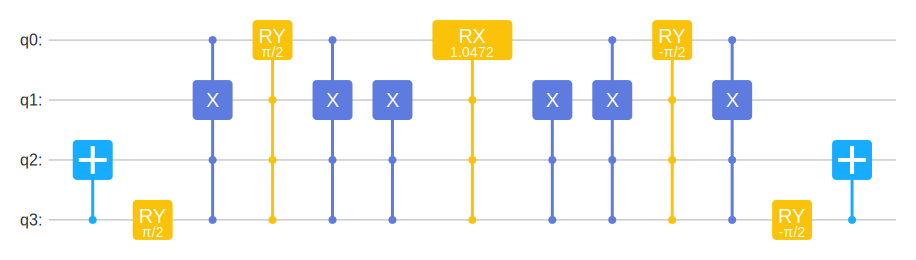

In [5]:
# Qubit ansatz of qutrit controlled rotation gate
d = 3
m = 1
name = 'X'
ind = [0, 1]
t = np.pi / 3
# print(GCR(name, d, ind, t, m))

p = np.eye(2**((d - 1) * 2)) - su2_encoding(np.eye(d**2), 2)
GCRe = su2_encoding(GCR(name, d, ind, t, m), 2)
GCRp = GCRe + p
# print(GCRp)

circ = Circuit()
if m == 0:
    if ind == [0, 1]:
        corr = Circuit() + X(2) + X(3) + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(
            1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(2) + X(3) + X(0, [2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(2) + X(3) + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
elif m == 1:
    if ind == [0, 1]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(0, [2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
elif m == 2:
    if ind == [0, 1]:
        corr = Circuit() + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(0, [2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
circ += corr
if name == 'X':
    circ = circ + RX(t).on(0, [1, 2, 3])
elif name == 'Y':
    circ = circ + RY(t).on(0, [1, 2, 3])
elif name == 'Z':
    circ = circ + RZ(t).on(0, [1, 2, 3])
circ += corr.hermitian()
print(circ.matrix())
print(np.allclose(GCRp, circ.matrix()))
circ.svg()

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
[[ 1.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  1.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j 

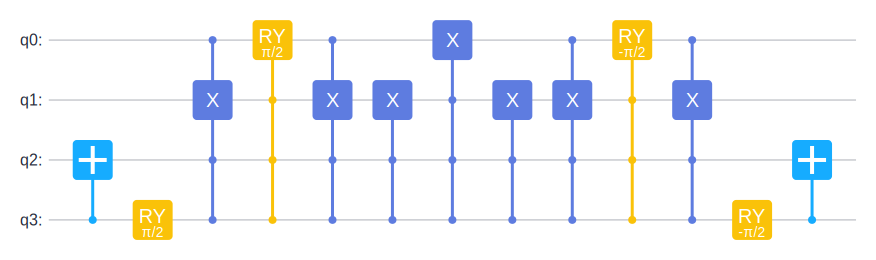

In [6]:
# Qubit ansatz of qutrit controlled Pauli gate
d = 3
m = 1
name = 'X'
ind = [0, 1]
print(GCP(name, d, ind, m))

p = np.eye(2**((d - 1) * 2)) - su2_encoding(np.eye(d**2), 2)
GCPe = su2_encoding(GCP(name, d, ind, m), 2)
GCPp = GCPe + p
# print(GCPp)

circ = Circuit()
if m == 0:
    if ind == [0, 1]:
        corr = Circuit() + X(2) + X(3) + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(2) + X(3) + X(0, [2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(2) + X(3) + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
elif m == 1:
    if ind == [0, 1]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(0, [2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
elif m == 2:
    if ind == [0, 1]:
        corr = Circuit() + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(0, [2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
circ += corr
if name == 'X':
    circ = circ + X(0, [1, 2, 3])
elif name == 'Y':
    circ = circ + Y(0, [1, 2, 3])
elif name == 'Z':
    circ = circ + Z(0, [1, 2, 3])
circ += corr.hermitian()
print(circ.matrix())
print(np.allclose(GCPp, circ.matrix()))
circ.svg()

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[ 1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.       

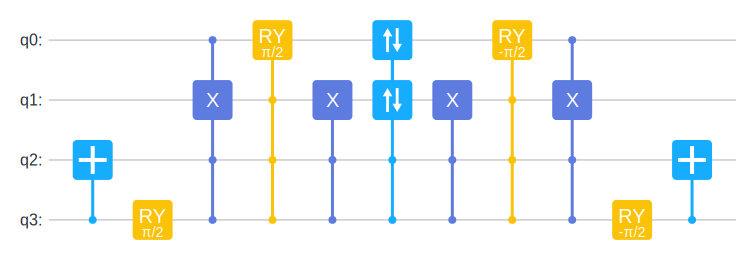

In [7]:
# Qubit ansatz of qutrit GCX gate
d = 3
m = 1
ind = [0, 1]
print(GCX(d, ind, m).real)

p = np.eye(2**((d - 1) * 2)) - su2_encoding(np.eye(d**2), 2)
GCXe = su2_encoding(GCX(d, ind, m), 2)
GCXp = GCXe + p
# print(GCXp.real)

circ = Circuit()
if m == 0:
    if ind == [0, 1]:
        corr = Circuit() + X(2) + X(3) + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(2) + X(3) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(2) + X(3) + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3])
elif m == 1:
    if ind == [0, 1]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(2, 3) + RY(np.pi / 2).on(3) + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3])
elif m == 2:
    if ind == [0, 1]:
        corr = Circuit() + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [2, 3])
    elif ind == [0, 2]:
        corr = Circuit() + X(0, [2, 3])
    elif ind == [1, 2]:
        corr = Circuit() + X(1, [0, 2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3])
circ += corr
circ = circ + SWAP([0, 1], [2, 3])
circ += corr.hermitian()
print(circ.matrix().real)
print(np.allclose(GCXp, circ.matrix()))
circ.svg()

[[-0.10091651+0.7406338j  -0.40966659+0.52292515j  0.        +0.j        ]
 [-0.4533024 -0.48558662j  0.16451039+0.72914944j  0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          1.        +0.j        ]]
[[-0.10091651+0.7406338j  -0.28967802+0.36976392j -0.28967802+0.36976392j  0.        +0.j        ]
 [-0.3205332 -0.34336159j  0.58225519+0.36457472j -0.41774481+0.36457472j  0.        +0.j        ]
 [-0.3205332 -0.34336159j -0.41774481+0.36457472j  0.58225519+0.36457472j  0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j          1.        +0.j        ]]
[[-0.10091651+0.7406338j  -0.28967802+0.36976392j -0.28967802+0.36976392j -0.        +0.j        ]
 [-0.3205332 -0.34336159j  0.58225519+0.36457472j -0.41774481+0.36457472j  0.        +0.j        ]
 [-0.3205332 -0.34336159j -0.41774481+0.36457472j  0.58225519+0.36457472j  0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j          1.   

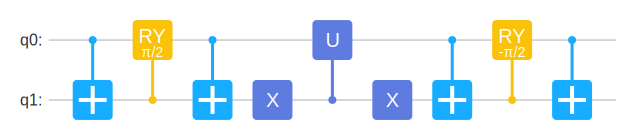

In [8]:
# Qubit ansatz of one-qutrit unitary gate
d = 3
ind = [0, 1]
U = unitary_group.rvs(2)
Ud = np.eye(d, dtype=np.complex128)
Ud[np.ix_(ind, ind)] = U
print(Ud)

p = np.eye(2**(d - 1)) - su2_encoding(np.eye(d))
Ue = su2_encoding(Ud)
Up = Ue + p
print(Up)

circ = Circuit()
if ind == [0, 1]:
    corr = Circuit() + X(1, 0) + RY(np.pi / 2).on(0, 1) + X(1, 0) + X(1)
elif ind == [0, 2]:
    corr = Circuit() + X(0) + X(1, 0) + X(0)
elif ind == [1, 2]:
    corr = Circuit() + X(1, 0) + RY(-np.pi / 2).on(0, 1) + X(1, 0)
circ += corr
circ += UnivMathGate('U', U).on(0, 1)
circ += corr.hermitian()
print(circ.matrix())
print(np.allclose(Up, circ.matrix()))
circ.svg()

[[0.8660254+0.j  0.       -0.5j 0.       +0.j ]
 [0.       -0.5j 0.8660254+0.j  0.       +0.j ]
 [0.       +0.j  0.       +0.j  1.       +0.j ]]
[[ 0.8660254+0.j          0.       -0.35355339j  0.       -0.35355339j  0.       +0.j        ]
 [ 0.       -0.35355339j  0.9330127+0.j         -0.0669873+0.j          0.       +0.j        ]
 [ 0.       -0.35355339j -0.0669873+0.j          0.9330127+0.j          0.       +0.j        ]
 [ 0.       +0.j          0.       +0.j          0.       +0.j          1.       +0.j        ]]
[[ 0.8660254+0.j          0.       -0.35355339j  0.       -0.35355339j  0.       +0.j        ]
 [ 0.       -0.35355339j  0.9330127+0.j         -0.0669873+0.j          0.       +0.j        ]
 [ 0.       -0.35355339j -0.0669873+0.j          0.9330127+0.j          0.       +0.j        ]
 [ 0.       +0.j          0.       +0.j          0.       +0.j          1.       +0.j        ]]
True


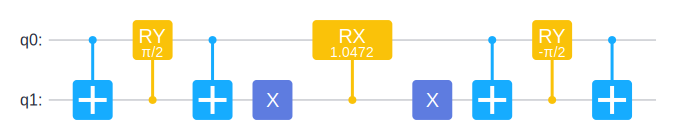

In [9]:
# Qubit ansatz of one-qutrit unitary gate
d = 3
name = 'X'
ind = [0, 1]
pr = np.pi / 3
print(Rd(name, d, ind, pr))

p = np.eye(2**(d - 1)) - su2_encoding(np.eye(d))
Re = su2_encoding(Rd(name, d, ind, pr))
Rp = Re + p
print(Rp)

circ = Circuit()
if ind == [0, 1]:
    corr = Circuit() + X(1, 0) + RY(np.pi / 2).on(0, 1) + X(1, 0) + X(1)
elif ind == [0, 2]:
    corr = Circuit() + X(0) + X(1, 0) + X(0)
elif ind == [1, 2]:
    corr = Circuit() + X(1, 0) + RY(-np.pi / 2).on(0, 1) + X(1, 0)
circ += corr
if name == 'X':
    circ = circ + RX(t).on(0, 1)
elif name == 'Y':
    circ = circ + RY(t).on(0, 1)
elif name == 'Z':
    circ = circ + RZ(t).on(0, 1)
circ += corr.hermitian()
print(circ.matrix())
print(np.allclose(Rp, circ.matrix()))
circ.svg()

[[0.+0.j 0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j]]
[[ 0.        +0.j  0.        +0.j  0.        +0.j  1.        +0.j]
 [ 0.70710678+0.j  0.5       +0.j -0.5       +0.j  0.        +0.j]
 [ 0.70710678+0.j -0.5       +0.j  0.5       +0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.70710678+0.j  0.        +0.j]]
[[ 0.        +0.j  0.        +0.j  0.        +0.j  1.        +0.j]
 [ 0.70710678+0.j  0.5       +0.j -0.5       +0.j  0.        +0.j]
 [ 0.70710678+0.j -0.5       +0.j  0.5       +0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.70710678+0.j  0.        +0.j]]
True


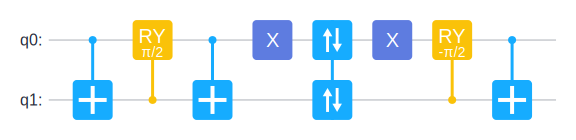

In [10]:
# Qubit ansatz of qutrit INC gate
d = 3
p = np.eye(2**(d - 1)) - su2_encoding(np.eye(d))
q = {i: np.eye(d)[i] for i in range(d)}

state = q[0] + q[1]
state /= norm(state)
# str_ket(d, state)
# str_ket(d, INC @ state)
print(INC(d))

INCe = su2_encoding(INC(d))
INCp = INCe + p
# print(INCe)
print(INCp)
# str_ket(2, su2_encoding(state))
# str_ket(2, INCp @ su2_encoding(state))

circ = Circuit() + X(1, 0) + RY(np.pi / 2).on(0, 1) + X(1, 0) + X(0) + SWAP([0, 1]) + X(0) + RY(-np.pi / 2).on(0, 1) + X(1, 0)
print(circ.matrix())
print(np.allclose(INCp, circ.matrix()))
circ.svg()

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]]
True


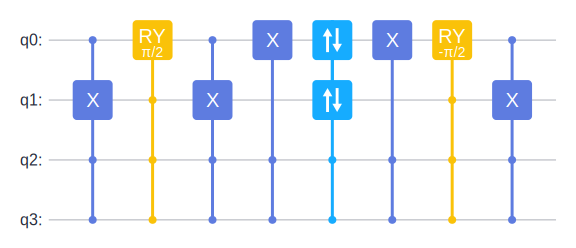

In [11]:
# Qubit ansatz of qutrit CINC gate
d = 3
print(CINC(d).real)

p = np.eye(2**((d - 1) * 2)) - su2_encoding(np.eye(d**2), 2)
CINCe = su2_encoding(CINC(d), 2)
CINCp = CINCe + p
# print(CINCp.real)
circ = Circuit() + X(1, [0, 2, 3]) + RY(np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3]) + X(0, [2, 3])
circ += SWAP([0, 1], [2, 3])
circ = circ + X(0, [2, 3]) + RY(-np.pi / 2).on(0, [1, 2, 3]) + X(1, [0, 2, 3])
# print(circ.matrix().real)
print(np.allclose(CINCp, circ.matrix()))
circ.svg()

In [12]:
d, m = 3, 2
nq = (d - 1) * m
n = 2**nq
sym_ind(3, 2)

ind_ = {}
for i in range(2**(d - 1)):
    num1 = bin(i).count('1')
    i_ = bin(i)[2::].zfill(d - 1)
    if num1 in ind_:
        ind_[num1].append(i_)
    else:
        ind_[num1] = [i_]
for i in range(d**m):
    multi = ['']
    base = np.base_repr(i, d).zfill(m)
    for j in range(m):
        multi = [x + y for x in multi for y in ind_[int(base[j])]]
    print(f'{i}|{base}⟩ -> ', end='')
    for j in multi:
        print(f'|{j}⟩ ', end='')
        # print(f'{int(j, 2)}|{j}⟩ ', end='')
    print()

0|00⟩ -> |0000⟩ 
1|01⟩ -> |0001⟩ |0010⟩ 
2|02⟩ -> |0011⟩ 
3|10⟩ -> |0100⟩ |1000⟩ 
4|11⟩ -> |0101⟩ |0110⟩ |1001⟩ |1010⟩ 
5|12⟩ -> |0111⟩ |1011⟩ 
6|20⟩ -> |1100⟩ 
7|21⟩ -> |1101⟩ |1110⟩ 
8|22⟩ -> |1111⟩ 


In [13]:
# Qudit
d = 3
nq = d - 1
n = 2**nq
for i in range(d):
    for j in range(d):
        a = f'a{str(i)}{str(j)}|{str(i)}⟩⟨{str(j)}|'
        print(a, end=' ')
    print()
print()
# Qubit
for i in range(n):
    for j in range(n):
        ii = bin(i)[2:].zfill(nq)
        jj = bin(j)[2:].zfill(nq)
        a = f'a{str(i)}{str(j)}|{ii}⟩⟨{jj}|'
        print(a, end=' ')
    print()

a00|0⟩⟨0| a01|0⟩⟨1| a02|0⟩⟨2| 
a10|1⟩⟨0| a11|1⟩⟨1| a12|1⟩⟨2| 
a20|2⟩⟨0| a21|2⟩⟨1| a22|2⟩⟨2| 

a00|00⟩⟨00| a01|00⟩⟨01| a02|00⟩⟨10| a03|00⟩⟨11| 
a10|01⟩⟨00| a11|01⟩⟨01| a12|01⟩⟨10| a13|01⟩⟨11| 
a20|10⟩⟨00| a21|10⟩⟨01| a22|10⟩⟨10| a23|10⟩⟨11| 
a30|11⟩⟨00| a31|11⟩⟨01| a32|11⟩⟨10| a33|11⟩⟨11| 


In [14]:
# Qudit
d = 4
nq = d - 1
n = 2**nq
print('\\begin{pmatrix}')
for i in range(d):
    for j in range(d):
        a = f'a_{{{str(i)}{str(j)}}}'
        if j < d - 1:
            print(a, end=' & ')
        else:
            print(a, end=' \\\\\n')
print('\\end{pmatrix}')
print()
# Qubit
ind = {}
for i in range(n):
    num1 = bin(i).count('1')
    ind[i] = [num1]
print(ind)
print('\\begin{pmatrix}')
for i in range(d):
    for j in range(d):
        a = f'a_{{{str(ind[i][0])}{str(ind[j][0])}}}'
        if j < d - 1:
            print(a, end=' & ')
        else:
            print(a, end=' \\\\\n')
print('\\end{pmatrix}')

\begin{pmatrix}
a_{00} & a_{01} & a_{02} & a_{03} \\
a_{10} & a_{11} & a_{12} & a_{13} \\
a_{20} & a_{21} & a_{22} & a_{23} \\
a_{30} & a_{31} & a_{32} & a_{33} \\
\end{pmatrix}

{0: [0], 1: [1], 2: [1], 3: [2], 4: [1], 5: [2], 6: [2], 7: [3]}
\begin{pmatrix}
a_{00} & a_{01} & a_{01} & a_{02} \\
a_{10} & a_{11} & a_{11} & a_{12} \\
a_{10} & a_{11} & a_{11} & a_{12} \\
a_{20} & a_{21} & a_{21} & a_{22} \\
\end{pmatrix}


In [15]:
d = 3
n = 2**(d - 1)
a1 = unitary_group.rvs(d)
a2 = su2_encoding(a1)
print(a1)
print(a2)
p = np.eye(n) - su2_encoding(np.eye(d))
print(p)
a2 += p
is_unitary(a2), is_symmetric(a2)

[[ 0.70294006+0.03118885j  0.07149122-0.03163382j -0.32562695+0.62670402j]
 [-0.58979256-0.32180129j -0.08381644+0.28570668j -0.52579407+0.4283407j ]
 [ 0.1075851 -0.20473555j  0.82823819+0.46824812j -0.03587238-0.19996792j]]
[[ 0.70294006+0.03118885j  0.05055192-0.02236849j  0.05055192-0.02236849j -0.32562695+0.62670402j]
 [-0.41704632-0.22754787j -0.04190822+0.14285334j -0.04190822+0.14285334j -0.37179255+0.30288261j]
 [-0.41704632-0.22754787j -0.04190822+0.14285334j -0.04190822+0.14285334j -0.37179255+0.30288261j]
 [ 0.1075851 -0.20473555j  0.58565284+0.33110142j  0.58565284+0.33110142j -0.03587238-0.19996792j]]
[[ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0.5+0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j  0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]]


(True, False)

In [16]:
d = 3
n = 2**(d - 1)
i1 = np.eye(d)
i2 = su2_encoding(i1)
p = np.eye(n) - su2_encoding(np.eye(d))
print(i1)
print(i2)
print(p)
is_symmetric(i2), matrix_rank(i2)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 1. +0.j]]
[[ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0.5+0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j  0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]]


(True, 3)

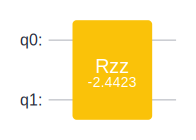

(True, True, True)

In [17]:
# U2⊗U2 Rxx Ryy Rzz SWAP preserve symmetry
d = 3
a1 = unitary_group.rvs(d)
b1 = np.random.rand(d) + 1j * np.random.rand(d)
b1 /= norm(b1)
a2 = su2_encoding(a1)
b2 = su2_encoding(b1)
# print(a1)
# print(a2)
# print(b1)
# print(b2)
t = np.random.uniform(-np.pi, np.pi)
k = Circuit() + Rzz(t).on([0, 1])
# k = Circuit() + UN(UnivMathGate('', unitary_group.rvs(2)), 2)
display_svg(k.svg())
k = k.matrix()
# print(k)
# print(a2 @ k)
# print(k @ a2)
# print(k @ b2)
is_symmetric(a2 @ k), is_symmetric(k @ a2), is_symmetric(k @ b2)

In [18]:
# How to restore a reduce density matrix
np.random.seed(42)
a = np.random.rand(2) + 1j * np.random.rand(2)
b = np.random.rand(2) + 1j * np.random.rand(2)
a /= norm(a)
b /= norm(b)
psi_ab = np.kron(a, b)
rho_a = np.outer(a, a.conj())
rho_b = np.outer(b, b.conj())
rho_ab = np.kron(rho_a, rho_b)
print(rho_a)
print(rho_b)
print(rho_ab)
print(psi_ab.conj() @ rho_ab @ psi_ab)
fidelity(rho_ab, psi_ab)

[[0.34880034-4.71109104e-18j 0.40977999+2.43349593e-01j]
 [0.40977999-2.43349593e-01j 0.65119966-1.91180564e-17j]]
[[0.03454462+1.57127038e-19j 0.0930421 -1.57144687e-01j]
 [0.0930421 +1.57144687e-01j 0.96545538+5.22244966e-18j]]
[[ 1.20491735e-02-1.07936862e-19j  3.24531155e-02-5.48121201e-02j  1.41556919e-02+8.40641803e-03j  7.63678855e-02-4.17529910e-02j]
 [ 3.24531155e-02+5.48121201e-02j  3.36751167e-01-2.72675600e-18j -1.14305675e-04+8.70365046e-02j  3.95624296e-01+2.34943175e-01j]
 [ 1.41556919e-02-8.40641803e-03j -1.14305675e-04-8.70365046e-02j  2.24954416e-02-5.58104827e-19j  6.05889828e-02-1.02332567e-01j]
 [ 7.63678855e-02+4.17529910e-02j  3.95624296e-01-2.34943175e-01j  6.05889828e-02+1.02332567e-01j  6.28704218e-01-1.50567731e-17j]]
(1.0000000000000007-5.551115123125783e-17j)


1.0000000000000002